Unzip datasets and prepare data:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from multi_imbalance.resampling.SOUP import SOUP
from multi_imbalance.resampling.spider import SPIDER3
from multi_imbalance.utils.data import construct_flat_2pc_df
import numpy as np

%matplotlib inline
sns.set_style('darkgrid')


# TODO replace it by correct file in repository
ecoli_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data'
df = pd.read_csv(ecoli_url, delim_whitespace=True, header=None,
                 names=['name', '1', '2', '3', '4', '5', '6', '7', 'class'])

X, y = df.iloc[:, 1:8].to_numpy(), df['class'].to_numpy()
print(X[:5])
print(y[:5])

[[0.49 0.29 0.48 0.5  0.56 0.24 0.35]
 [0.07 0.4  0.48 0.5  0.54 0.35 0.44]
 [0.56 0.4  0.48 0.5  0.49 0.37 0.46]
 [0.59 0.49 0.48 0.5  0.52 0.45 0.36]
 [0.23 0.32 0.48 0.5  0.55 0.25 0.35]]
['cp' 'cp' 'cp' 'cp' 'cp']


Resample data using SPIDER3 algorithm

In [3]:
cost = np.random.rand(64).reshape((8, 8))  # np.ones((8, 8))
for i in range(8):
    cost[i][i] = 0

clf = SPIDER3(k=1, cost=cost, majority_classes=['cp', 'im'],
              intermediate_classes=['pp', 'imU', 'om'], minority_classes=['imS', 'imL', 'omL'])
resampled_X, resampled_y = clf.fit_transform(X, y)

Compare results by plotting data in 2 dimensions

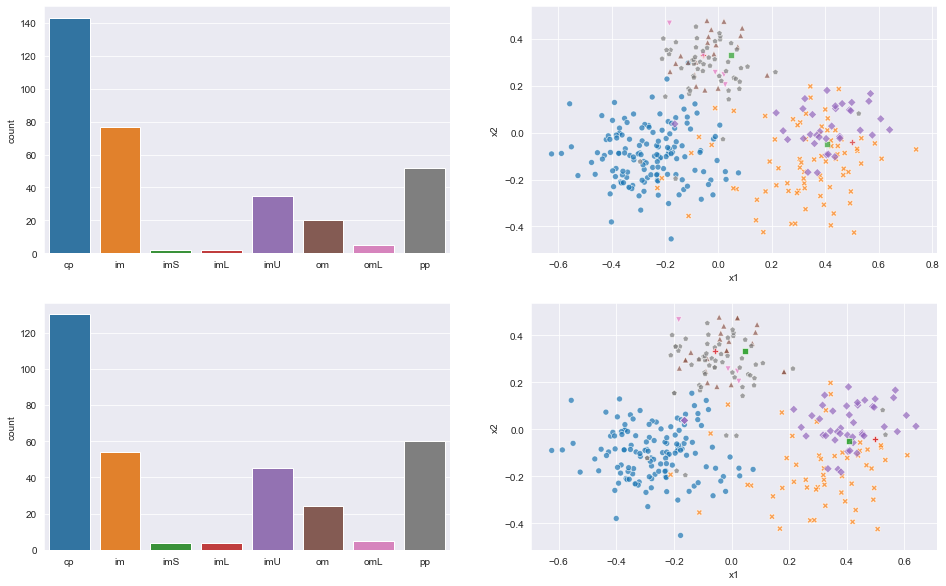

In [4]:
pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches( 16, 10)
axs = axs.flatten()

sns.countplot(y, ax=axs[0])
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend=False)

sns.countplot(resampled_y, ax=axs[2])
resampled_X = pca.transform(resampled_X)
df = construct_flat_2pc_df(resampled_X, resampled_y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[3], legend=False)